In [1]:
from cells.bind import VertexModel

import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from pathlib import Path
from operator import itemgetter

sys.path.append("analysis/utils/")
import config_functions   as config
import vm_output_handling as vm_output
from plot_utils import hist_to_curve

sys.path.append("analysis/experimental/")
from data_class import SegmentationData

In [79]:
# LOAD EXPERIMENTAL DATA
binsize = 200
density = 1900

masks = []
cellprops = []

# Add experimental data
for dataset in ["holomonitor_20240319_A1-13"]:
                #"holomonitor_20240301_B1-4",
                #"holomonitor_20240319_B1-11",
                #"holomonitor_20240319_A1-9",
                #"holomonitor_20240319_A1-13"]:

    cellprop = SegmentationData()
    cellprop.load(f"data/experimental/processed/{dataset}/cell_props.p")
    cellprop.add_density()

    mask = (cellprop.density > density - binsize / 2) * (cellprop.density < density + binsize / 2)

    masks.append(mask)
    cellprops.append(cellprop)

State loaded from data/experimental/processed/holomonitor_20240319_A1-13/cell_props.p.


In [101]:
# LOAD SIMULATION DATA
date  = 20251126
gamma = 20
v0    = 100
taup  = 100
eta   = 50

paths = [f"data/simulated/raw/nodivision_{date}_N42_L600_gamma{gamma}_v0{v0}_taup{taup}_eta{eta}.p",
         f"data/simulated/raw/nodivision_{date}_N42_L600_gamma{gamma}_v0{v0-20}_taup{taup}_eta{eta}.p"]

list_vms = []
for filepath in paths:
    config_path = f"data/simulated/configs/{Path(filepath).stem}.json"
    config_file = config.load(config_path)

    # Compute time period between frames
    dt = config_file["simulation"]["dt"]
    T  = config_file["simulation"]["period"]
    df = T * dt

    # Load frames as vm objects
    list_vm, init_vm = vm_output.load(filepath, df=df)
    list_vms.append(list_vm)


In [ ]:
# GET CELL PROPERTIES
cell_heights       = vm_output.get_cell_heights(list_vm)
cell_volumes       = vm_output.get_cell_volumes(list_vm)
cell_velocities    = vm_output.get_cell_velocities(list_vm)
cell_aspect_ratios = vm_output.get_cell_aspect_ratios(list_vm)

cell_areas      = cell_volumes / cell_heights
cell_speeds     = np.sqrt(cell_velocities[:,:,0]**2 + cell_velocities[:,:,1]**2)

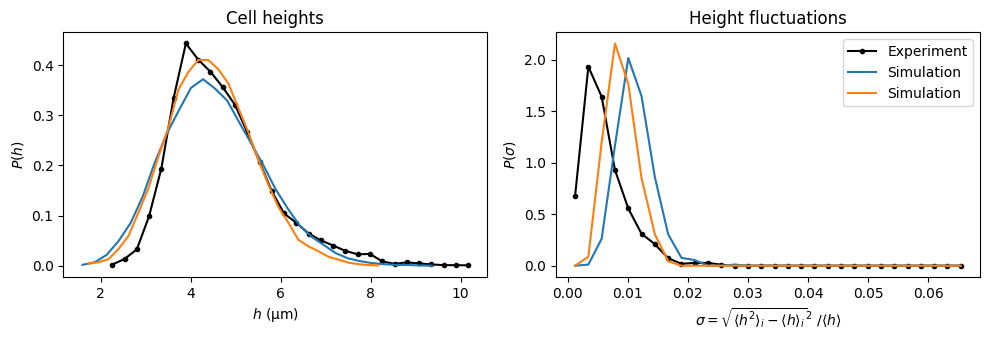

In [ ]:
# experiment
tmp_dist  = []
tmp_std   = []

for cellprop, mask in zip(cellprops, masks):
    tmp_dist.append(     (cellprop.h[mask]).ravel())
    tmp_std.append(np.ma.std(cellprop.h[mask], axis=0))

tmp_dist  = np.ma.concatenate(tmp_dist)
tmp_std   = np.ma.concatenate(tmp_std)

dist_exp = hist_to_curve(tmp_dist, 30)
std_exp  = hist_to_curve(tmp_std,  30, hist_range=[1e-2, np.ma.mean(tmp_dist)])

# simulation
dist_sim = []
std_sim  = []
for list_vm in list_vms:
    cell_heights = vm_output.get_cell_heights(list_vm)

    dist_sim.append(hist_to_curve(cell_heights, 30))
    std_sim.append(hist_to_curve(np.ma.std(cell_heights, axis=0), 30, hist_range=[1e-2, np.ma.mean(tmp_dist)]))

scaled_std_exp = std_exp[0] / np.ma.mean(tmp_dist)
# scaled_std_sim = std_sim[0] / np.ma.mean(dist_sim[0])

scaled_std_exp /= np.ma.sum(scaled_std_exp)
# scaled_std_sim /= np.ma.sum(scaled_std_sim)

plt.figure(figsize=(10,3.5))

plt.subplot(121)
plt.plot(dist_exp[0], dist_exp[1], 'k.-', label="Experiment")
for i in range(len(paths)):
    plt.plot(dist_sim[i][0], dist_sim[i][1], label="Simulation")
plt.title("Cell heights")
plt.xlabel(r"$h$ (µm)")
plt.ylabel(r"$P(h)$")

plt.subplot(122)
plt.plot(scaled_std_exp,    std_exp[1], 'k.-', label="Experiment")
for i in range(len(paths)):
    scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
    scaled_std_sim /= np.ma.sum(scaled_std_sim)
    plt.plot(scaled_std_sim, std_sim[i][1], label="Simulation")
plt.legend()
plt.title("Height fluctuations")
plt.xlabel(r"$\sigma=\sqrt{\langle h^2 \rangle_i - \langle h \rangle_i}^2~/ \langle h \rangle$")
plt.ylabel(r"$P(\sigma)$")
plt.tight_layout()

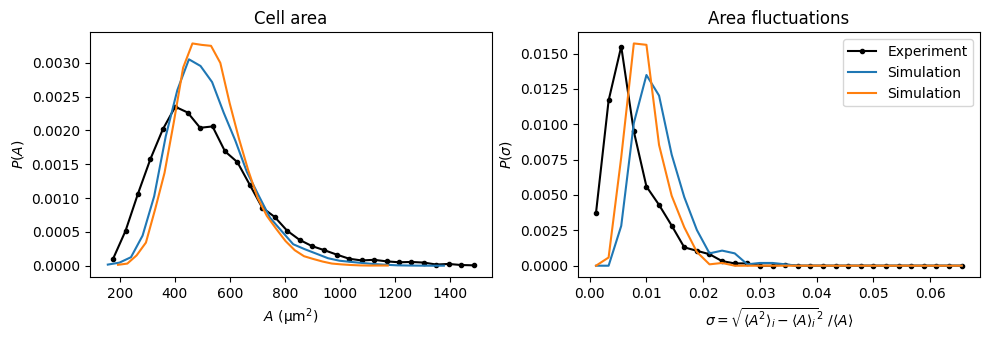

In [ ]:
# experiment
tmp_dist = []
tmp_std  = []
for cellprop, mask in zip(cellprops, masks):
    tmp_dist.append(     (cellprop.A[mask]).ravel())
    tmp_std.append(np.ma.std(cellprop.A[mask], axis=0))

tmp_dist = np.ma.concatenate(tmp_dist)
tmp_std  = np.ma.concatenate(tmp_std)

dist_exp = hist_to_curve(tmp_dist, 30)
std_exp  = hist_to_curve(tmp_std,  30, hist_range=[1e-2, np.ma.mean(tmp_dist)])
    
# simulation
dist_sim = []
std_sim  = []
for list_vm in list_vms:
    cell_heights = vm_output.get_cell_heights(list_vm)
    cell_volumes = vm_output.get_cell_volumes(list_vm)
    cell_areas   = cell_volumes / cell_heights

    dist_sim.append(hist_to_curve(cell_areas, 30))
    std_sim.append(hist_to_curve(np.ma.std(cell_areas, axis=0), 30, hist_range=[1e-2, np.ma.mean(tmp_dist)]))

# normalize
scaled_std_exp = std_exp[0] / np.ma.mean(tmp_dist)
#scaled_std_sim = std_sim[0] / np.ma.mean(dist_sim[0])

scaled_std_exp /= np.ma.sum(scaled_std_exp)
#scaled_std_sim /= np.ma.sum(scaled_std_sim)


plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.plot(dist_exp[0], dist_exp[1], 'k.-', label="Experiment")
for i in range(len(paths)):
    plt.plot(dist_sim[i][0], dist_sim[i][1], label="Simulation")
plt.title("Cell area")
plt.xlabel(r"$A$ (µm$^2$)")
plt.ylabel(r"$P(A)$")

plt.subplot(122)
plt.plot(scaled_std_exp, std_exp[1], 'k.-', label="Experiment")
for i in range(len(paths)):
    scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
    scaled_std_sim /= np.ma.sum(scaled_std_sim)
    plt.plot(scaled_std_sim, std_sim[i][1], label="Simulation")
plt.legend()
plt.legend()
plt.title("Area fluctuations")
plt.xlabel(r"$\sigma=\sqrt{\langle A^2 \rangle_i - \langle A \rangle_i}^2~/ \langle A \rangle$")
plt.ylabel(r"$P(\sigma)$")

plt.tight_layout()

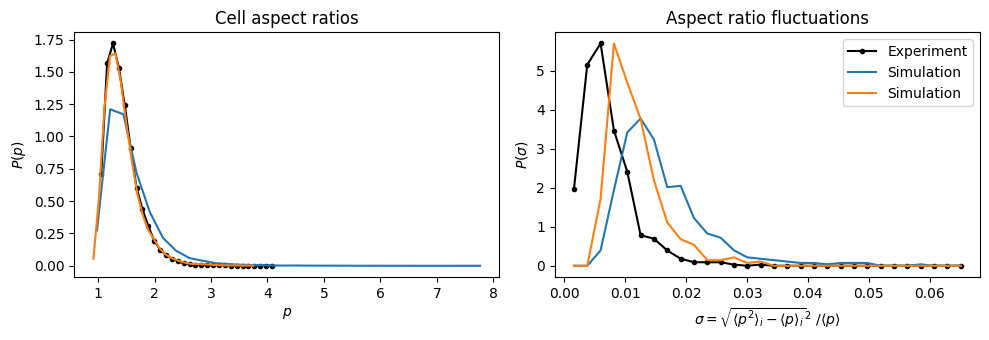

In [109]:
# experiment
tmp_dist = []
tmp_std  = []
for cellprop, mask in zip(cellprops, masks):
    tmp_dist.append(     (cellprop.amajor[mask] / cellprop.aminor[mask]).ravel())
    tmp_std.append(np.std(cellprop.amajor[mask] / cellprop.aminor[mask], axis=0))

tmp_dist = np.ma.concatenate(tmp_dist)
tmp_std  = np.ma.concatenate(tmp_std)

dist_exp = hist_to_curve(tmp_dist, 30)
std_exp  = hist_to_curve(tmp_std,  30, hist_range=[1e-2, np.mean(tmp_dist)])

# simulation
dist_sim = []
std_sim  = []
for list_vm in list_vms:
    cell_aspect_ratios = vm_output.get_cell_aspect_ratios(list_vm)

    dist_sim.append(hist_to_curve(cell_aspect_ratios, 30))
    std_sim.append(hist_to_curve(np.ma.std(cell_aspect_ratios, axis=0), 30, hist_range=[1e-2, np.ma.mean(tmp_dist)]))

# normalize
scaled_std_exp = std_exp[0] / np.ma.mean(tmp_dist)
#scaled_std_sim = std_sim[0] / np.ma.mean(dist_sim[0])

scaled_std_exp /= np.ma.sum(scaled_std_exp)
#scaled_std_sim /= np.ma.sum(scaled_std_sim)


plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.plot(dist_exp[0], dist_exp[1], 'k.-', label="Experiment")
for i in range(len(paths)):
    plt.plot(dist_sim[i][0], dist_sim[i][1], label="Simulation")
plt.title("Cell aspect ratios")
plt.xlabel(r"$p$")
plt.ylabel(r"$P(p)$")

plt.subplot(122)
plt.plot(scaled_std_exp, std_exp[1], 'k.-', label="Experiment")
for i in range(len(paths)):
    scaled_std_sim = std_sim[i][0] / np.ma.mean(dist_sim[i][0])
    scaled_std_sim /= np.ma.sum(scaled_std_sim)
    plt.plot(scaled_std_sim, std_sim[i][1], label="Simulation")
plt.legend()
plt.title("Aspect ratio fluctuations")
plt.xlabel(r"$\sigma=\sqrt{\langle p^2 \rangle_i - \langle p \rangle_i}^2~/ \langle p \rangle$")
plt.ylabel(r"$P(\sigma)$")

plt.tight_layout()

Text(0, 0.5, '$P(v_{rms})$')

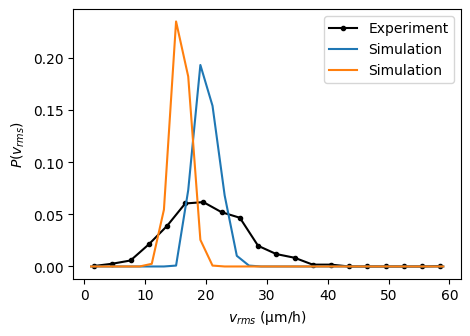

In [111]:
tmp_dist = []
for cellprop, mask in zip(cellprops, masks):
    speed = np.ma.sqrt(cellprop.dx[mask[:-1]]**2 + cellprop.dy[mask[:-1]]**2)
    vrms  = np.ma.sqrt(np.ma.mean(speed**2, axis=0)) * 12

    tmp_dist.append((vrms).ravel())

tmp_dist = np.ma.concatenate(tmp_dist)
vrms_exp = hist_to_curve(tmp_dist, 20, hist_range=[0.1, 60])

vrms_sims = []
for list_vm in list_vms:

    cell_velocities    = vm_output.get_cell_velocities(list_vm)
    cell_speeds     = np.sqrt(cell_velocities[:,:,0]**2 + cell_velocities[:,:,1]**2)
    vrms_sims.append(hist_to_curve(np.sqrt(np.ma.mean(cell_speeds**2, axis=0)), 30, hist_range=[0.1, 60]))



plt.figure(figsize=(5,3.5))
plt.plot(vrms_exp[0], vrms_exp[1], 'k.-', label="Experiment")
for vrms_sim in vrms_sims:
    plt.plot(vrms_sim[0], vrms_sim[1], label="Simulation")
plt.legend()
plt.xlabel(r"$v_{rms}$ (µm/h)")
plt.ylabel(r"$P(v_{rms})$")
